# Regression Models Template

This notebook demonstrates linear, logistic, and ordinal regression using the waste charging policy dataset.

## Libraries
We will use:
- pandas for data handling
- numpy for numerical operations
- scikit-learn for linear and logistic regression
- statsmodels for ordinal regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("D:\\Incoming\\202526_S1\\GCAP3226\\GCAP3226_week3.csv")

# Display the first few rows to verify
df.head()

,ID,support_info,support_after_info,fairness,government_consideration,policy_helpfulness_original,policy_helpfulness,waste_severity,recycling_effort,food_waste_behavior,...,recycle_frequency,household_size,Q1_score,Q2_score,Q3_score,total_score,height,Distance to Nearest Recycling Facility,error,Distance_artificial
0,1,1,1,1,1,1,1,3,1,never_seen,...,1,0,0,1,0,1,1.72,400,-10.263397,259.826667
1,2,5,5,5,5,5,4,2,2,never_seen,...,2,1,0,1,1,2,1.85,300,90.062855,260.040000
2,3,3,5,5,4,2,2,3,1,seen_not_used,...,1,3,0,1,0,1,1.72,400,108.336080,338.893333
3,4,1,2,2,1,2,2,3,2,never_seen,...,2,0,0,1,1,2,1.67,300,-11.113667,192.593333
4,5,1,3,4,3,1,1,3,2,seen_not_used,...,2,2,0,1,1,2,1.84,300,49.418514,232.946667


In [3]:
# Recode household monthly income into a single variable with midpoints
conditions = [
    df['HouseholdMonthlyIncomeRange_Below15k'] == 1,
    df['HouseholdMonthlyIncomeRange_15,001-30,000'] == 1,
    df['HouseholdMonthlyIncomeRange_30,001-50,000'] == 1,
    df['HouseholdMonthlyIncomeRange_50,001-70,000'] == 1,
    df['HouseholdMonthlyIncomeRange_AboveHK70k'] == 1
]
income_values = [10, 22.5, 40, 60, 90]  # midpoints in thousands

df['income'] = np.select(conditions, income_values, default=np.nan)
print("Income variable created with these value counts:")
print(df['income'].value_counts().sort_index())

Income variable created with these value counts:
income
10.0     7
22.5    19
40.0    28
60.0    24
90.0    19
Name: count, dtype: int64


In [4]:
# Recode education level into a single ordinal variable
conditions = [
    df['HighestEducationLevel_Primaryorbelow'] == 1,
    df['HighestEducationLevel_Secondary'] == 1,
    df['HighestEducationLevel_DiplomaorBachelor'] == 1,
    df['HighestEducationLevel_Masterorabove'] == 1
]
education_values = [1, 2, 3, 4]  # ordinal values for education levels

df['education'] = np.select(conditions, education_values, default=np.nan)
print("\nEducation variable created with these value counts:")
print(df['education'].value_counts().sort_index())


Education variable created with these value counts:
education
1.0     2
2.0     7
3.0    33
4.0    55
Name: count, dtype: int64


In [5]:
# Recode age from binary columns to a single 'age' column with midpoints
age_columns = ['AgeRange_18-24', 'AgeRange_25-34', 'AgeRange_35-44', 'AgeRange_45-54', 'AgeRange_55-64', 'AgeRange_65+']
midpoints = [20, 30, 40, 50, 60, 70]

# Create 'age' column by finding the midpoint where the binary is 1
df['age'] = np.nan
for col, midpoint in zip(age_columns, midpoints):
    df.loc[df[col] == 1, 'age'] = midpoint

# Handle any missing ages if necessary (e.g., drop or impute)
df = df.dropna(subset=['age'])  # Example: drop rows with missing age

# Verify the new 'age' column
df['age'].value_counts()

age
40.0    26
30.0    23
50.0    22
20.0    19
60.0     6
70.0     1
Name: count, dtype: int64

## Part 1: Linear Regression

We first treat 'support_info' as a continuous variable for linear regression purposes.

### Simple Linear Regression: support_info vs fairness

In [6]:
# Create centered versions of fairness and government_consideration
df['fairness_c'] = df['fairness'] - df['fairness'].mean()
df['government_consideration_c'] = df['government_consideration'] - df['government_consideration'].mean()

print("Summary of original and centered variables:")
print("\nOriginal fairness:")
print(df['fairness'].describe())
print("\nCentered fairness:")
print(df['fairness_c'].describe())
print("\nOriginal government_consideration:")
print(df['government_consideration'].describe())
print("\nCentered government_consideration:")
print(df['government_consideration_c'].describe())

Summary of original and centered variables:

Original fairness:
count    97.000000
mean      2.948454
std       1.158044
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: fairness, dtype: float64

Centered fairness:
count    9.700000e+01
mean    -1.831296e-16
std      1.158044e+00
min     -1.948454e+00
25%     -9.484536e-01
50%      5.154639e-02
75%      1.051546e+00
max      2.051546e+00
Name: fairness_c, dtype: float64

Original government_consideration:
count    97.000000
mean      2.505155
std       1.081316
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       5.000000
Name: government_consideration, dtype: float64

Centered government_consideration:
count    9.700000e+01
mean     1.831296e-17
std      1.081316e+00
min     -1.505155e+00
25%     -5.051546e-01
50%      4.948454e-01
75%      4.948454e-01
max      2.494845e+00
Name: government_consideration_c, dtype: float64


Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8351      0.090     31.579      0.000       2.657       3.013
fairness_c     0.7936      0.078     10.184      0.000       0.639       0.948

R-squared: 0.5219


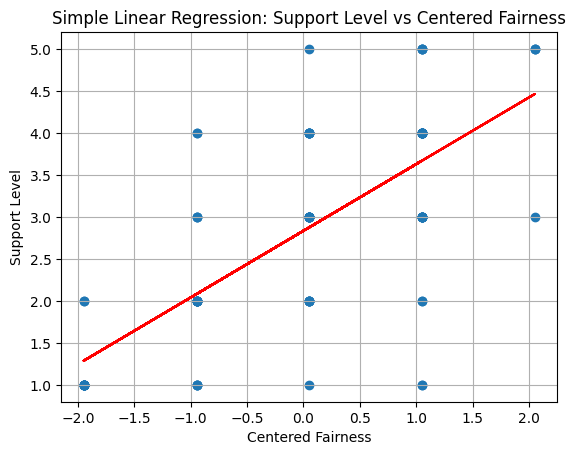

In [7]:
# Prepare data
X1 = df[['fairness_c']].dropna()
y = df.loc[X1.index, 'support_info']

# Fit model using sklearn for predictions
lin_reg1 = LinearRegression()
lin_reg1.fit(X1, y)

# Fit model using statsmodels for statistical tests
X1_sm = sm.add_constant(X1)  # Add constant term for intercept
model = sm.OLS(y, X1_sm)
results = model.fit()

# Predictions for plotting
y_pred1 = lin_reg1.predict(X1)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Plot
plt.scatter(X1, y)
plt.plot(X1, y_pred1, color='red')
plt.xlabel('Centered Fairness')
plt.ylabel('Support Level')
plt.title('Simple Linear Regression: Support Level vs Centered Fairness')
plt.grid(True)
plt.show()

#### Interpreting Simple Linear Regression Results

The output above shows several key statistics:

1. **Coefficient Statistics Table:**
   - `coef`: The estimated coefficient value
   - `P>|t|`: p-value     

   P-value is the probability of obtaining the sample results (e.g., estimated coefficient values), or an even more extreme result, if the null hypothesis (that the coefficient equals zero) is true. If p-value is very small, this means that observing our sample result would be very unlikely under the null hypothesis (coefficient = 0). Given that we have observed such an unusual result, we have evidence to reject the null hypothesis and conclude that the coefficient is significantly different from zero.
   - `[0.025 0.975]`: 95% confidence interval

2. **How to interpret:**
   - If p-value < 0.05, a commonly used threshold which is called the significance level, the coefficient is significantly different from 0
   - Coefficient shows the average change in support_info for a one-unit increase in fairness
   - R-squared shows the proportion of variance explained by the model (0 to 1, higher is better). It measures model’s explanatory power.

3. **Plot interpretation:**
   - Scatter points show actual data
   - Red line shows the estimated relationship between variables
   - The closer points are to the line, the better the model fit

#### Interpreting Coefficients Estimate with Likert Scale Response Variable

When interpreting regression results with a Likert scale (1-5) response variable:

1. **Constant ($\hat \beta_0$) = 2.8351 (p < 0.001)**
   - This represents the predicted baseline support level (when fairness = mean fairness)
   - Statistically significant (p < 0.05)

2. **Fairness coefficient ($\hat \beta_1$) = 0.7936 (p < 0.001)**
   - For each one-unit increase in perceived fairness, support is expected to increase by 0.7936 points
   - This is a strong positive relationship (close to 1 point increase for each point increase in fairness)
   - Highly significant (p < 0.001)

3. **Practical Example:**
   - If someone rates fairness as 3 ("neutral"):
     * Predicted support = 2.8351 + (0.7936 × (3-2.9485)) = 2.8760
   - If they rate fairness as 4 ("fair"):
     * Predicted support = 2.8351 + (0.7936 × (4-2.9485)) = 3.6696
   - This shows how higher fairness ratings associate with meaningfully higher support levels

4. **R-squared** indicates how much of the variation in support levels can be explained by perceived fairness alone.

### Simple Linear Regression 2: support_info vs Distance_artificial

Model Summary:
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.1969      0.404      5.432      0.000       1.394       3.000
Distance_artificial     0.0034      0.002      1.663      0.100      -0.001       0.007

R-squared: 0.0283


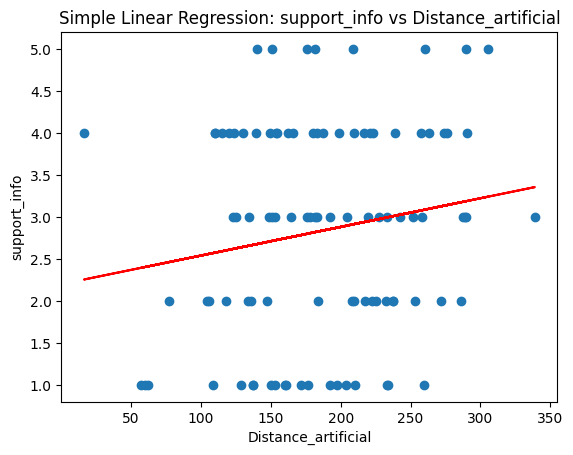

In [8]:
# Prepare data
X2 = df[['Distance_artificial']].dropna()
y = df.loc[X2.index, 'support_info']

# Fit model using sklearn for predictions
lin_reg2 = LinearRegression()
lin_reg2.fit(X2, y)

# Fit model using statsmodels for statistical tests
X2_sm = sm.add_constant(X2)  # Add constant term for intercept
model = sm.OLS(y, X2_sm)
results = model.fit()

# Predictions for plotting
y_pred2 = lin_reg2.predict(X2)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Plot
plt.scatter(X2, y)
plt.plot(X2, y_pred2, color='red')
plt.xlabel('Distance_artificial')
plt.ylabel('support_info')
plt.title('Simple Linear Regression: support_info vs Distance_artificial')
plt.show()

**Distance coefficient ($\hat \beta_1$) = 0.0034 (p = 0.1 > 0.05)**
   - There's no significant association between the distance to the recycle facilities to the level of support
   - Distance to the recycle facilities can only explain a very limited proportion of variance in the level of support


### Multiple Linear Regression: support_info vs all collected variables

In [9]:
# To fit multiple linear regression using all collected variables; response variable is support_info. 
# Using centered versions of all continuous variables for better interpretability

# Center the remaining continuous variables that haven't been centered yet
df['recycling_effort_c'] = df['recycling_effort'] - df['recycling_effort'].mean()
df['income_c'] = df['income'] - df['income'].mean()
df['education_c'] = df['education'] - df['education'].mean()
df['recycle_frequency_c'] = df['recycle_frequency'] - df['recycle_frequency'].mean()
df['household_size_c'] = df['household_size'] - df['household_size'].mean()
df['total_score_c'] = df['total_score'] - df['total_score'].mean()
df['policy_helpfulness_c'] = df['policy_helpfulness'] - df['policy_helpfulness'].mean()
df['waste_severity_c'] = df['waste_severity'] - df['waste_severity'].mean()
df['age_c'] = df['age'] - df['age'].mean()


# Use centered versions of continuous variables
features = ['fairness_c', 'government_consideration_c', 'policy_helpfulness_c', 'waste_severity_c', 'recycling_effort_c',
            'LocalResidentcode', 'DailyWasteBags_More than 1 bag', 'DailyWasteBags_Exactly 1 bag',
            'HousingType_Other', 'HousingType_Private housing', 'HousingType_Subsidized housing',
            'age_c', 'income_c', 'education_c', 'recycle_frequency_c', 'household_size_c', 'total_score_c']

X_multi = df[features].dropna()     
y_multi = df.loc[X_multi.index, 'support_info'] 

# Fit model using sklearn
lin_reg_multi = LinearRegression()  
lin_reg_multi.fit(X_multi, y_multi)

# Fit model using statsmodels for statistical tests
X_multi_sm = sm.add_constant(X_multi)  # Add constant term for intercept
model = sm.OLS(y_multi, X_multi_sm)
results = model.fit()

print("Multiple Linear Regression Results with All Centered Variables:")
print("\nModel Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Model significance
print("\nModel Diagnostics:")
print(f"F-statistic: {results.fvalue:.2f}")
print(f"Prob (F-statistic): {results.f_pvalue:.4f}")        # Overall model significance
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Calculate VIF for continuous variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get indices of continuous variables (excluding dummy variables)
continuous_vars = ['fairness_c', 'government_consideration_c', 'policy_helpfulness_c', 'waste_severity_c', 'recycling_effort_c',
                  'age_c', 'income_c', 'education_c', 'recycle_frequency_c', 'household_size_c', 'total_score_c']
continuous_indices = [features.index(var) for var in continuous_vars]

# Calculate VIF for continuous variables only
vif_data = pd.DataFrame()
vif_data["Variable"] = continuous_vars
vif_data["VIF"] = [variance_inflation_factor(X_multi.values, i) for i in continuous_indices]

print("\nVariance Inflation Factors for Continuous Variables:")
print(vif_data.sort_values('VIF', ascending=False))

Multiple Linear Regression Results with All Centered Variables:

Model Summary:
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              2.3574      0.397      5.933      0.000       1.567       3.148
fairness_c                         0.3925      0.112      3.505      0.001       0.170       0.615
government_consideration_c         0.4325      0.124      3.481      0.001       0.185       0.680
policy_helpfulness_c               0.1446      0.123      1.177      0.243      -0.100       0.389
waste_severity_c                   0.1847      0.160      1.153      0.252      -0.134       0.504
recycling_effort_c                -0.1026      0.137     -0.748      0.457      -0.376       0.170
LocalResidentcode                 -0.0444      0.229     -0.194      0.847      -0.500       0.411
DailyWasteBags_More than 1 ba

#### Interpreting Multiple Linear Regression Results

The output shows several important statistics:

1. **Coefficient Statistics Table:**
   - Each row represents one predictor variable
   - Interpretation is similar to simple regression, but now each coefficient represents the estimated effect while **holding other variables constant**
   - P>|t| < 0.05 indicates statistical significance

2. **Model Quality Metrics:**
   - R-squared: Proportion of variance explained by all predictors together (0 to 1, higher is better)
   - F-statistic and its p-value: Tests if the model as a whole is significant
     - If Prob (F-statistic) < 0.05, the model is statistically significant

3. **Coefficients:**
   - Positive coefficients indicate positive relationships
   - Negative coefficients indicate negative relationships
   - Compare standardized coefficients to assess relative importance, the larger absolute values, the stronger the effects

### Forward Selection for Multiple Linear Regression

We'll perform forward selection using the following steps:
1. Start with no predictors
2. Add variables one at a time based on lowest p-value
3. Stop when no remaining variables have p-value < 0.05
4. Compare final model with full model

In [10]:
# Perform forward selection
def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    selected_features = []
    remaining_features = initial_features.copy()
    
    print('Forward Selection Progress:\n')
    
    while remaining_features:
        best_pvalue = float('inf')
        best_feature = None
        
        # Try each remaining feature
        for feature in remaining_features:
            # Create model with current selected features plus the new candidate
            candidate_features = selected_features + [feature]
            X_candidate = X[candidate_features]
            
            # Fit model and get p-value for the new feature
            X_with_const = sm.add_constant(X_candidate)
            model = sm.OLS(y, X_with_const).fit()
            
            # Get p-value for the last added feature using proper indexing
            # The last feature will be the candidate feature we just added
            pvalue = model.pvalues.iloc[-1] if len(model.pvalues) > 0 else float('inf')
            
            # Update best feature if this one has lower p-value
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                best_feature = feature
        
        # If best feature meets significance criterion, add it
        if best_pvalue < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            
            # Fit model with all selected features
            X_selected = X[selected_features]
            X_with_const = sm.add_constant(X_selected)
            model = sm.OLS(y, X_with_const).fit()
            
            print(f'Step {len(selected_features)}:')
            print(f'Added feature: {best_feature}')
            print(f'P-value: {best_pvalue:.4f}')
            print(f'Current R-squared: {model.rsquared:.4f}\n')
        else:
            break
    
    # Fit final model
    if selected_features:
        X_final = X[selected_features]
        X_with_const = sm.add_constant(X_final)
        final_model = sm.OLS(y, X_with_const).fit()
        
        print('Final Model Summary:')
        print('Selected features:', ', '.join(selected_features))
        print('\nCoefficient Statistics:')
        print(final_model.summary().tables[1])
        print(f'\nFinal R-squared: {final_model.rsquared:.4f}')
        print(f'Adjusted R-squared: {final_model.rsquared_adj:.4f}')
        
        return selected_features, final_model
    else:
        print('No features were selected.')
        return [], None

# Run forward selection
selected_features, final_model = forward_selection(X_multi, y_multi)

Forward Selection Progress:

Step 1:
Added feature: government_consideration_c
P-value: 0.0000
Current R-squared: 0.5517

Step 2:
Added feature: fairness_c
P-value: 0.0001
Current R-squared: 0.6219

Final Model Summary:
Selected features: government_consideration_c, fairness_c

Coefficient Statistics:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.8351      0.080     35.321      0.000       2.676       2.994
government_consideration_c     0.5426      0.109      4.985      0.000       0.326       0.759
fairness_c                     0.4248      0.102      4.179      0.000       0.223       0.627

Final R-squared: 0.6219
Adjusted R-squared: 0.6139


#### Interpreting Forward Selection Results

The forward selection process:
1. Started with no variables and added them one at a time
2. At each step, selected the variable with the lowest p-value
3. Only added variables if their p-value was < 0.05
4. Continued until no remaining variables met the significance criterion

Compare the forward selection model with the full model:
- Which variables were selected?
- How does the R-squared compare?
- Is the simpler model adequate?

This helps identify the most important predictors while potentially reducing model complexity.

## Part 2: Logistic Regression

When the response variable is binary (oppose/support), which violates certain assumption of multiple linear regression model, we change to predict the chance of support.

Recode 'support_info' to binary 'Support_binary' (1/2 -> 0; 4/5 -> 1; exclude 3)

In [11]:
# Recode support_info to Support_binary
df['Support_binary'] = np.nan
df.loc[df['support_info'].isin([1, 2]), 'Support_binary'] = 0
df.loc[df['support_info'].isin([4, 5]), 'Support_binary'] = 1

# Drop rows where Support_binary is NaN (i.e., original 3)
df_log = df.dropna(subset=['Support_binary'])

### Logistic Regression 1: Support_binary vs fairness

In [12]:
# Prepare data
X_log1 = df_log[['fairness_c']].dropna()
y_log = df_log.loc[X_log1.index, 'Support_binary']

# Fit model using sklearn for predictions
log_reg1 = LogisticRegression()
log_reg1.fit(X_log1, y_log)

# Fit model using statsmodels for statistical tests
X_log1_sm = sm.add_constant(X_log1)  # Add constant term for intercept
model = sm.Logit(y_log, X_log1_sm)
results = model.fit(method='newton')

# Predictions and metrics
y_pred_log1 = log_reg1.predict(X_log1)
acc1 = accuracy_score(y_log, y_pred_log1)
conf1 = confusion_matrix(y_log, y_pred_log1)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
#print(conf1)

#Additional model diagnostics
print("\nModel Diagnostics:")
print(f"Log-Likelihood: {results.llf:.2f}")
print(f"Pseudo R-squared: {results.prsquared:.4f}")
print(f"LLR p-value: {results.llr_pvalue:.4f}")  # Overall model significance

Optimization terminated successfully.
         Current function value: 0.377056
         Iterations 7
Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1395      0.345     -0.405      0.686      -0.816       0.537
fairness_c     1.9254      0.411      4.689      0.000       1.121       2.730

Model Diagnostics:
Log-Likelihood: -27.90
Pseudo R-squared: 0.4549
LLR p-value: 0.0000


#### Interpreting Logistic Regression Results

The output includes several important measures:

1. **Coefficient Statistics Table:**
   - `coef`: Log odds ratio
   - `P>|z|`: p-value (statistical significance)
   - `[0.025 0.975]`: 95% confidence interval

2. **Model Quality Metrics:**
   - Pseudo R-squared: Measure of model fit (higher is better)
   - Log-Likelihood: Used for model comparison (higher is better)
   - LLR p-value: Tests if model is better than null model

3. **Interpreting Coefficients:**
   - A positive coefficient for fairness indicates that a one-unit increase in perceived fairness is associated with an 1.9254 unites increase in log-odds
   - Odds ratio $e^{1.9254} = 6.86$. Higher percieved fairness, higher chance of supporting policy vs opposing

### Logistic Regression 2: Support_binary vs fairness + government_consideration, policy_helpfulness, waste_severity, age

### Logistic Regression using forward selection

We'll perform forward selection to identify the most important predictors.

In [13]:
# Perform forward selection for logistic regression
def logistic_forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    selected_features = []
    remaining_features = initial_features.copy()
    
    print('Forward Selection Progress:\n')
    
    while remaining_features:
        best_pvalue = float('inf')
        best_feature = None
        
        # Try each remaining feature
        for feature in remaining_features:
            # Create model with current selected features plus the new candidate
            candidate_features = selected_features + [feature]
            X_candidate = X[candidate_features]
            
            # Fit model and get p-value for the new feature
            X_with_const = sm.add_constant(X_candidate)
            model = sm.Logit(y, X_with_const).fit(method='newton', disp=0)
            
            # Get p-value for the last added feature (excluding constant)
            pvalue = model.pvalues.iloc[-1] if len(model.pvalues) > 0 else float('inf')
            
            # Update best feature if this one has lower p-value
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                best_feature = feature
        
        # If best feature meets significance criterion, add it
        if best_pvalue < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            
            # Fit model with all selected features
            X_selected = X[selected_features]
            X_with_const = sm.add_constant(X_selected)
            model = sm.Logit(y, X_with_const).fit(method='newton', disp=0)
            
            print(f'Step {len(selected_features)}:')
            print(f'Added feature: {best_feature}')
            print(f'P-value: {best_pvalue:.4f}')
            print(f'Current Pseudo R-squared: {model.prsquared:.4f}\n')
        else:
            break
    
    # Fit final model
    if selected_features:
        X_final = X[selected_features]
        X_with_const = sm.add_constant(X_final)
        final_model = sm.Logit(y, X_with_const).fit(method='newton')
        
        print('Final Model Summary:')
        print('Selected features:', ', '.join(selected_features))
        print('\nCoefficient Statistics:')
        print(final_model.summary().tables[1])
        print(f'\nPseudo R-squared: {final_model.prsquared:.4f}')
        print(f'Log-Likelihood: {final_model.llf:.2f}')
        print(f'LLR p-value: {final_model.llr_pvalue:.4f}')
        
        return selected_features, final_model
    else:
        print('No features were selected.')
        return [], None

# Prepare data for forward selection with centered variables
features_log = ['fairness_c', 'government_consideration_c', 'policy_helpfulness_c', 'waste_severity_c', 
                'recycling_effort_c', 'LocalResidentcode', 'DailyWasteBags_More than 1 bag', 
                'DailyWasteBags_Exactly 1 bag', 'HousingType_Other', 'HousingType_Private housing', 
                'HousingType_Subsidized housing', 'age_c', 'income_c', 'education_c', 
                'recycle_frequency_c', 'household_size_c', 'total_score_c']
                
X_log_full = df_log[features_log].dropna()
y_log_full = df_log.loc[X_log_full.index, 'Support_binary']

# Run forward selection
print("Running Forward Selection for Logistic Regression with Centered Variables:")
selected_features_log, final_model_log = logistic_forward_selection(X_log_full, y_log_full)

Running Forward Selection for Logistic Regression with Centered Variables:
Forward Selection Progress:

Step 1:
Added feature: fairness_c
P-value: 0.0000
Current Pseudo R-squared: 0.4549

Step 2:
Added feature: government_consideration_c
P-value: 0.0008
Current Pseudo R-squared: 0.6550

Optimization terminated successfully.
         Current function value: 0.238666
         Iterations 8
Final Model Summary:
Selected features: fairness_c, government_consideration_c

Coefficient Statistics:
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.1421      0.456     -0.312      0.755      -1.035       0.751
fairness_c                     1.3407      0.573      2.338      0.019       0.217       2.465
government_consideration_c     2.4502      0.727      3.368      0.001       1.024       3.876

Pseudo R-squared: 0.6550
Log-L

#### Interpreting Logistic Regression Feature Selection Results

1. **Full Model vs Selected Model:**
   - Compare the Pseudo R-squared values
   - Check which features were retained
   - Look for changes in coefficient magnitudes and significance

2. **Selected Features:**
   - Most important predictors of support/opposition
   - Check coefficient signs (positive = increases odds of support)
   - Calculate odds ratios: exp(coefficient) for interpretation

3. **Model Parsimony:**
   - Simpler model may be preferred if performance is similar
   - Check if important theoretical variables were retained
   - Consider practical significance of selected features

## Part 3: Ordinal Regression

Recode 'support_info' to ordinal 'Support_ordinal' (1/2 -> 0; 3 -> 1; 4/5 -> 2)

Using statsmodels OrderedModel for proper ordinal regression.

In [14]:
# Recode support_info to Support_ordinal
df['Support_ordinal'] = np.nan
df.loc[df['support_info'].isin([1, 2]), 'Support_ordinal'] = 1
df.loc[df['support_info'] == 3, 'Support_ordinal'] = 2
df.loc[df['support_info'].isin([4, 5]), 'Support_ordinal'] = 3

# Drop rows where Support_ordinal is NaN (if any)
df_ord = df.dropna(subset=['Support_ordinal'])

# Display frequency table of Support_ordinal
print("Frequency table of Support_ordinal:")
print("\nValue counts:")
print(df_ord['Support_ordinal'].value_counts().sort_index())
print("\nPercentages:")
print(df_ord['Support_ordinal'].value_counts(normalize=True).sort_index().multiply(100).round(2), "%")
print("\nInterpretation:")
print("1: Oppose (original values 1-2)")
print("2: Neutral (original value 3)")
print("3: Support (original values 4-5)")

Frequency table of Support_ordinal:

Value counts:
Support_ordinal
1.0    39
2.0    23
3.0    35
Name: count, dtype: int64

Percentages:
Support_ordinal
1.0    40.21
2.0    23.71
3.0    36.08
Name: proportion, dtype: float64 %

Interpretation:
1: Oppose (original values 1-2)
2: Neutral (original value 3)
3: Support (original values 4-5)


### Ordinal Regression 1: Support_ordinal vs fairness

In [15]:
# Prepare data
df_ord['fairness_c'] = df_ord['fairness'] - df_ord['fairness'].mean()
X_ord1 = df_ord[['fairness_c']]
y_ord = df_ord['Support_ordinal']

# Fit model
ord_reg1 = OrderedModel(y_ord, X_ord1, distr='logit')
result1 = ord_reg1.fit(method='bfgs')

print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.792489
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
                             OrderedModel Results                             
Dep. Variable:        Support_ordinal   Log-Likelihood:                -76.871
Model:                   OrderedModel   AIC:                             159.7
Method:            Maximum Likelihood   BIC:                             167.5
Date:                Tue, 16 Sep 2025                                         
Time:                        08:47:22                                         
No. Observations:                  97                                         
Df Residuals:                      94                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

#### Interpreting Ordinal Regression Results

The output includes several components:

1. **Model Summary Statistics:**
   - Log-Likelihood
   - LL-null: Log-likelihood of null model
   - LLR p-value: Test of model significance
   - AIC/BIC: Model comparison metrics (lower is better)

2. **Coefficient Table:**
   - The coefficient of `fairness_c` is 1.5784. Given the sign of $\beta$ in the model is negative, it means higher level of fairness is associated with lower log odds (roughtly likelihood) of opposition.
 
   - The coefficient of `1.0/2.0` is -0.5151. It implies that at the average fairness level, the log odds of opposition is -0.5151. This can be converted to the odds ratio of opposition $e^{-0.5151} = 0.5974$. This odds ratio can be converted to the probability of opposition as 0.5974/(1+0.5794) = 0.3782.
 
   - The coefficient of `2.0/3.0` is 0.4505. It means that at the average fairness level, the log odds of not support is 0.4505. This can be converted to the odds ratio of opposition is $e^{0.4505}$ = 1.5691. This odds ratio can be converted to the probability of not support is 1.5691/(1+1.5691) = 0.6108.

<Figure size 1200x600 with 0 Axes>

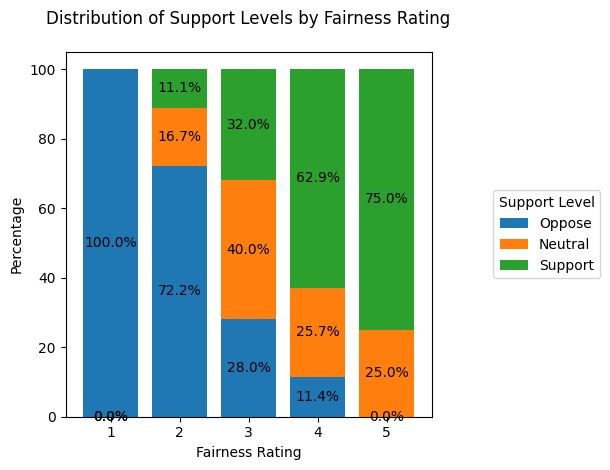


Percentage distribution of support levels by fairness rating:
Support_ordinal     1.0    2.0    3.0
fairness                             
1                100.00   0.00   0.00
2                 72.22  16.67  11.11
3                 28.00  40.00  32.00
4                 11.43  25.71  62.86
5                  0.00  25.00  75.00


In [16]:
# Create a cross-tabulation of fairness levels and support categories
fairness_support = pd.crosstab(df_ord['fairness'], df_ord['Support_ordinal'], normalize='index') * 100

# Create a stacked bar chart with increased figure size to accommodate the legend
plt.figure(figsize=(12, 6))

# Plot with stronger bars (increased width and added edge color)
ax = fairness_support.plot(kind='bar', 
                          stacked=True,
                          width=0.8   # Make bars wider
                          #edgecolor='black',  # Add black edges
                          #linewidth=1 # Edge line width
                          )  

# Customize the plot
plt.title('Distribution of Support Levels by Fairness Rating', pad=20)  # Add some padding to title
plt.xlabel('Fairness Rating')
plt.ylabel('Percentage')

# Move legend outside the plot area to the right
plt.legend(title='Support Level', 
          labels=['Oppose', 'Neutral', 'Support'],
          bbox_to_anchor=(1.15, 0.5),
          loc='center left')

# Make x-axis labels vertical
plt.xticks(rotation=0)

# Add percentage labels on the bars
for c in ax.containers:
    # Add percentage labels
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

# Adjust layout to prevent label cutoff and accommodate legend
plt.tight_layout()
plt.show()

# Print the actual percentages
print("\nPercentage distribution of support levels by fairness rating:")
print(fairness_support.round(2))

## Conclusion

This template provides the basic structure for the regressions. You can extend it with more visualizations, diagnostics, or interpretations as needed for the in-class exercise.